In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import keras
from PIL import Image
from imgaug import augmenters as iaa
from keras.applications.xception import Xception
from keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import pandas as pd
from IPython.display import display

## Initialize

In [2]:
PATH = "awe"
TRAIN_PATH = "TrainData"
total_subjects = 100
epochs = 50 
img_size = 200
batch_size = 64
          
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Xception

In [3]:
def dataset(mode): 
    total_images = []
    label =[]
    mode_path = os.path.join(PATH,mode)  # mode path -> awe/TrainData
    subjects = os.listdir(mode_path)  # 
    
    for subject in subjects:
        image_path  = os.path.join(mode_path,subject)
        images = os.listdir(image_path)
        for image in images:
            if(image.endswith(".png")):
                file = os.path.join(image_path,image)
                total_images.append(cv2.resize(cv2.imread(file),(200,200)))
                label.append(int(subject))
    total_images = np.array(total_images)
    label = np.array(label)
    return total_images , label

In [4]:
train,label = dataset('TrainData')

def split_data(data,label,valid_len):
    valid_len = int(valid_len*len(data)/100)
    return (data[0:len(data)-valid_len],label[0:len(data)-valid_len],
            data[len(data)-valid_len:len(data)],label[len(data)-valid_len:len(data)])

In [5]:
x_train,y_train,x_valid,y_valid = split_data(train,label,20)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(800, 200, 200, 3)
(200, 200, 200, 3)
(800,)
(200,)


In [6]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, total_subjects+1,dtype='int32')
y_valid = keras.utils.to_categorical(y_valid, total_subjects+1,dtype='int32')
y_train = y_train[:,0:total_subjects]
y_valid = y_valid[:,0:total_subjects]

In [7]:
base_modelX = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(x_train[0].shape))

#base_modelX.trainable = False
#inputs = keras.Input(shape=(img_size, img_size, 3))
#x = base_modelX(inputs, training=False)

x= base_modelX.output
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(total_subjects,activation='softmax')(x)

modelX = keras.Model(base_modelX.input, outputs)
modelX.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 99, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [8]:
for layer in base_modelX.layers:
    layer.trainable = False

In [9]:
modelX.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [10]:
historyX = modelX.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid, y_valid))

print(historyX.history)
print('Train loss:', historyX.history['loss'])
print('Train accuracy:', historyX.history['accuracy'])
print('Test loss:', historyX.history['val_loss'])
print('Test accuracy:', historyX.history['val_accuracy'])

Epoch 1/50
13/13 [==============================] - 10s 423ms/step - loss: 73.7508 - accuracy: 0.0089 - val_loss: 58.4953 - val_accuracy: 0.0050
Epoch 2/50
13/13 [==============================] - 3s 230ms/step - loss: 72.2684 - accuracy: 0.0097 - val_loss: 58.3312 - val_accuracy: 0.0050
Epoch 3/50
13/13 [==============================] - 3s 216ms/step - loss: 72.7464 - accuracy: 0.0133 - val_loss: 58.1639 - val_accuracy: 0.0050
Epoch 4/50
13/13 [==============================] - 3s 216ms/step - loss: 72.1775 - accuracy: 0.0063 - val_loss: 57.9942 - val_accuracy: 0.0050
Epoch 5/50
13/13 [==============================] - 3s 217ms/step - loss: 71.9472 - accuracy: 0.0055 - val_loss: 57.8235 - val_accuracy: 0.0050
Epoch 6/50
13/13 [==============================] - 3s 217ms/step - loss: 71.3353 - accuracy: 0.0068 - val_loss: 57.6499 - val_accuracy: 0.0050
Epoch 7/50
13/13 [==============================] - 3s 217ms/step - loss: 72.2840 - accuracy: 0.0099 - val_loss: 57.4751 - val_accuracy

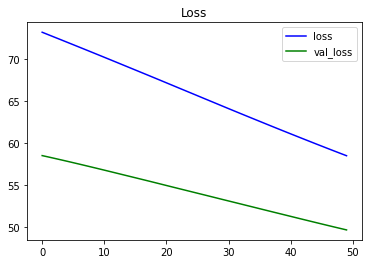

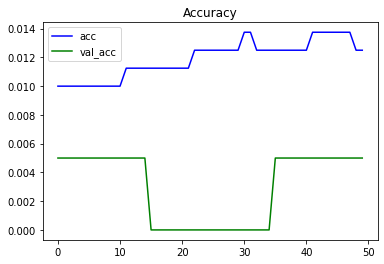

Test loss: 0.0
Test accuracy: 0.0


In [11]:
loss = historyX.history['loss']
val_loss = historyX.history['val_loss']
acc = historyX.history['accuracy']
val_acc = historyX.history['val_accuracy']
x = range(len(acc))

plt.figure()
plt.title("Loss")
plt.plot(x, loss, 'b', label='loss')
plt.plot(x, val_loss, 'g', label = 'val_loss' )
plt.legend()
plt.show()

plt.figure()
plt.title("Accuracy")
plt.plot(x, acc, 'b', label='acc')
plt.plot(x, val_acc, 'g', label ='val_acc')
plt.legend()
plt.show()

score = modelX.evaluate(x_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

